# MVTec-AD benchmark dataset on Unsupervised Quantum Anomaly Detection

Author : [Nishantak Panigrahi](https://github.com/nishantak)

---

In [1]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread

from IPython.display import display

Quantum Anomaly Detector

Trains on normal data then "like an autoencoder", instead of reconstruction error, it uses:
- Measurement distribution of a quantum circuit as a metric

- Compares test distributions to a "normal" baseline using KL 


In [ ]:
class QuantumAnomalyDetector:
    def __init__(self, num_qubits=6, shots=1024):
        self.num_qubits = num_qubits
        self.shots = shots
        self.simulator = AerSimulator()
        self.baseline_distribution = None  # How normal is supposed to look, we train on nomral so it learns and we dont need to hardcode.
        
    
    # Classical data ---> Quantum State Vector : 2^num_qubits
    def encode_data(self, data):
        data = data.flatten()   # HAZELNUT: 1024 X 1024 -> 2^20
        
        target_size = 2**self.num_qubits  # number of amplitudes, 3 bits can represent 2^3 = 8 amplitudes = len(Quantum State Vector)

        # Feature selection
        
        # We can only encode N = 2^n values: like input layer of NN; either downsample or extract features and feed to num_qubits qubits (hybrid)
        # ∣\psi⟩ = a_0​ ∣000...0⟩ + a_1 ​∣000...1⟩ +...+ a_{N-1} ​∣11...11⟩
        if len(data) > target_size:
            step = len(data) // target_size     # Downsample by taking N elements across the image
            data = data[::step][:target_size]
        if len(data) < target_size: data = np.pad(data, (0, target_size-len(data)), mode='constant')
        data = data[:target_size]
        
        
        # Encoding: Amplitude Encoding

        # Normalisation || \sum{|a_i|^2} = 1 because <\psi | \psi> = 1 : Born Rule
        norm = np.linalg.norm(data) # L2 Norm / Euclidean Norm: ||x|| = \sqrt{\sum{x_i^2}}
        if norm > 1e-10:  # if no 0 division

            data = data / norm  # unit vector now: x -> x / ||X||  => ||x|| = 1
            
            # Double Check because Qiskit is rude and double perc floating point is the bane of society
            actual_norm = np.linalg.norm(data)
            if not np.isclose(actual_norm, 1.0, atol=1e-10): data = data / actual_norm

        # if 0 division
        else: data = np.ones(target_size) / np.sqrt(target_size)  # -> Equal amplitudes
        

        # Final check and correction for floating point errors
        final_norm = np.sum(np.abs(data)**2) # norm^2 
        if not np.isclose(final_norm, 1.0, atol=1e-12): data = data / np.sqrt(final_norm)
        return data
    

    # Detection Circuit
    def quantum_circuit(self, encoded_data):
        qreg = QuantumRegister(self.num_qubits, 'q') # inputs
        creg = ClassicalRegister(self.num_qubits, 'c') # outputs
        circuit = QuantumCircuit(qreg, creg)
        
        # Initialize quantum state with encoded data : ∣\psi⟩ = \sum_{i=0}^{2^N-1}{ x_{i} ​∣\psi_i⟩ }
        circuit.initialize(encoded_data, qreg, normalize=True)
        
        # Quantum feature map (VQC not PQC, circuit param not trained - distribution is trained) : gives "effect" of the data to meaasure and comapre

        # Rotation : R_y(\theta)(x)
        for i in range(self.num_qubits):
            circuit.ry(np.pi/4, qreg[i])
        # Entanglment
        for i in range(self.num_qubits - 1):
            circuit.cx(qreg[i], qreg[i+1])
            
        # Simulate noise for generalisation
        for i in range(self.num_qubits):
            if np.random.random() < 0.23: # Realistic hardware noise
                circuit.rx(np.random.uniform(0, np.pi/8), qreg[i])

        # Measure in computational basis
        circuit.measure(qreg, creg)
        return circuit
    

    # Training: Learns what is normal -> Establish baseline
    # How? : learnign how the distribution of measurements of the above circuit looks for normal data
    def train_baseline(self, normal_data):
        distributions = []
        for i, sample in enumerate(normal_data):
            encoded = self.encode_data(sample.flatten())
            circuit = self.quantum_circuit(encoded)

            # if not i: display(circuit.draw("latex"))
            
            # Pass through circuit
            compiled_circuit = transpile(circuit, self.simulator) # Qiskit real backends: transpile optimises the circuit optimised for the simulator backend.
            job = self.simulator.run(compiled_circuit, shots=self.shots) # experiment
            counts = job.result().get_counts(compiled_circuit) # Count of each \psi_i basis state: {'00..00': 200, '00..01': 180, ..., '11..11': 140}

            
            # Get probability distribution
            prob_dist = np.zeros(2**self.num_qubits)
            for state, count in counts.items():
                prob_dist[int(state, 2)] = count/self.shots
            distributions.append(prob_dist)

        self.baseline_distribution = np.mean(distributions, axis=0) # distribution mean, can also store additional measures of tendency such as median, sd etc.
        

    # How far from baseline?
    def detect_anomaly(self, test_data):
        encoded = self.encode_data(test_data.flatten())
        circuit = self.quantum_circuit(encoded)
        
        # Execute circuit for input data
        compiled_circuit = transpile(circuit, self.simulator)
        job = self.simulator.run(compiled_circuit, shots=self.shots)
        counts = job.result().get_counts(compiled_circuit)
        
        # Get probability distribution
        prob_dist = np.zeros(2**self.num_qubits)
        for state, count in counts.items():
            prob_dist[int(state, 2)] = count/self.shots
        
        # Calculate KL divergence from baseline
        if self.baseline_distribution is not None:
            epsilon = 1e-10     # avoid log(0)
            
            baseline_smooth = self.baseline_distribution + epsilon
            prob_dist_smooth = prob_dist + epsilon
            
            # D_{KL}(P||Q) = \sum_{i}{ P_i * log(P_i / Q_i) } 
            kl_div = np.sum(prob_dist_smooth * np.log(prob_dist_smooth / baseline_smooth))
            return kl_div

In [ ]:
train_dir = "hazelnut/train/good"
def load_train_images(path, size=(1024, 1024)): # hazelnut images are 1024x1024
    imgs = []
    for file in glob.glob(os.path.join(path, "*.png")):
        img = Image.open(file).convert('L').resize(size)
        imgs.append(np.array(img) / 255.0)  # Normalize to [0, 1], 8-bit: L mode
    return imgs
train_imgs = load_train_images(train_dir)


test_dir = "hazelnut/test"
def load_test_images(test_dir, size=(1024, 1024)):
    imgs = []
    labels = []
    good_imgs = []
    categories = ['crack', 'cut', 'hole', 'print']
    
    for category in categories:
        cat_dir = os.path.join(test_dir, category)
        for file in glob.glob(os.path.join(cat_dir, "*.png")):
            img = Image.open(file).convert('L').resize(size)
            img_array = np.array(img) / 255.0
            imgs.append(img_array)
            labels.append(category)  # track which kind of anomaly it is
    
    # good samples
    cat_dir = os.path.join(test_dir, "good")
    for file in glob.glob(os.path.join(cat_dir, "*.png")):
        good_img = Image.open(file).convert('L').resize(size)
        good_img_array = np.array(good_img) / 255.0
        good_imgs.append(good_img_array)
        
    return imgs, labels, good_imgs
test_imgs, test_labels, good_imgs = load_test_images(test_dir)


gt_dir = "hazelnut/ground_truth"

Training


--- Training on 391 NORMAL samples ---



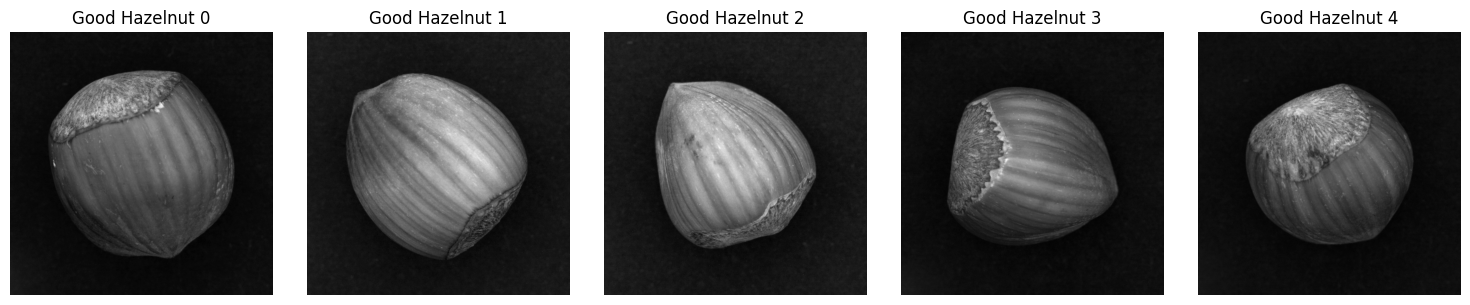

In [ ]:
detector = QuantumAnomalyDetector(num_qubits=20)

# Show some samples
print(f"\n--- Training on {len(train_imgs)} NORMAL samples ---\n")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(min(5, len(train_imgs))):
    axes[i].imshow(train_imgs[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Good Hazelnut {i}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()
    
detector.train_baseline(train_imgs)

In [7]:
print("\nTesting quantum anomaly detection...\n")

print("\n--- Set Baseline Divergence ---")
normal_scores = []
for i, sample in enumerate(train_imgs):
    score = detector.detect_anomaly(sample) 
    normal_scores.append(score)

print(f"\nNormal scores: mean={np.mean(normal_scores):.4f}, std={np.std(normal_scores):.4f}")


Testing quantum anomaly detection...


--- Set Baseline Divergence ---

Normal scores: mean=3.2092, std=0.2007


Testing

In [15]:
# Test on samples

# anomolous
print("\nTesting quantum anomaly detection...\n")
print(f"\n--- Testing on {len(test_imgs)} ANOMOLOUS TEST samples ---\n")
anomaly_scores = []
for i, sample in enumerate(test_imgs):
    score = detector.detect_anomaly(sample)
    anomaly_scores.append(score)

print(f"Test scores: mean={np.mean(anomaly_scores):.4f}, std={np.std(anomaly_scores):.4f}")

# good
print(f"\n--- Testing on {len(good_imgs)} GOOD TEST samples ---\n")
good_scores = []
for i, sample in enumerate(good_imgs):
    score = detector.detect_anomaly(sample)
    good_scores.append(score)

print(f"Test scores: mean={np.mean(good_scores):.4f}, std={np.std(good_scores):.4f}")


Testing quantum anomaly detection...


--- Testing on 70 ANOMOLOUS TEST samples ---

Test scores: mean=3.2875, std=0.2921

--- Testing on 40 GOOD TEST samples ---

Test scores: mean=3.0818, std=0.1493


Thresholding

The choice of the threshold value depends on the specific problem and the desired trade-off between detecting anomalies and avoiding false positives. A higher threshold value will result in fewer data points being classified as anomalies, while a lower threshold value will be more sensitive to anomalies but may also produce more false positives.

In [20]:
threshold = np.mean(normal_scores) + 1.2*np.std(normal_scores) # VIT Metrics
print(f"\nThreshold: {threshold:.4f}")

good_correct = sum(1 for score in good_scores if score<threshold)
anomaly_correct = sum(1 for score in anomaly_scores if score>=threshold)

total_samples = len(good_scores) + len(anomaly_scores)

accuracy = (good_correct + anomaly_correct) / total_samples

print(f"Detection accuracy: {accuracy:.2%}")

print(f"Good samples correctly classified: {good_correct}/{len(good_scores)}")
print(f"Anomalous samples correctly classified: {anomaly_correct}/{len(anomaly_scores)}")


Threshold: 3.4501
Detection accuracy: 56.36%
Good samples correctly classified: 40/40
Anomalous samples correctly classified: 22/70


NOT Good Enough

Original anomaly score: 2.8581

Perturbing superpixels...


100%|██████████| 529/529 [13:18<00:00,  1.51s/it]


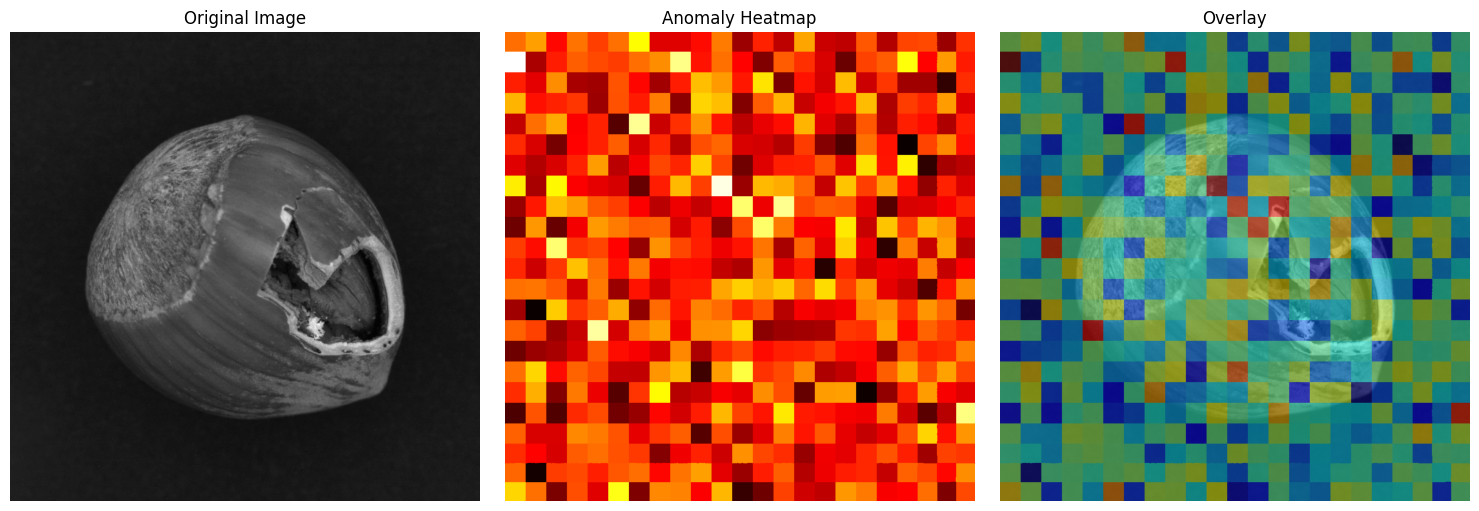

In [ ]:
from tqdm import tqdm
from skimage.segmentation import slic

image_path = "hazelnut/test/crack/001.png"
def load_image(path, size=(1024, 1024)):
    img = Image.open(path).convert('L').resize(size)
    return np.array(img) / 255.0  # Normalize to [0, 1]
img = load_image(image_path, size=(1024, 1024))

#  Superpixel-based Anomaly Heatmap Generator 
def generate_superpixel_anomaly_heatmap(detector, image, n_segments=256, compactness=5):

    segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=0, channel_axis=None)  # Segment image into superpixels
    
    h, w = image.shape
    heatmap = np.zeros((h, w))

    original_score = detector.detect_anomaly(image)
    print(f"Original anomaly score: {original_score:.4f}\n")

    print("Perturbing superpixels...")
    for label in tqdm(np.unique(segments)):
        perturbed = image.copy()
        mask = (segments == label)
        perturbed[mask] = 0.0  # Mask superpixel to 0

        perturbed_score = detector.detect_anomaly(perturbed)
        delta = np.abs(perturbed_score - original_score)

        heatmap[mask] = delta

    return heatmap

heatmap = generate_superpixel_anomaly_heatmap(detector, img)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='hot')
plt.title("Anomaly Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

Evaluating good samples: 100%|██████████| 40/40 [00:59<00:00,  1.48s/it]



=== CORRECTLY CLASSIFIED ANOMALIES ===


Visualizing Correct Anomaly:   0%|          | 0/5 [00:00<?, ?it/s]


Generating heatmap for Correct Anomaly Sample 1...
Segmenting image into superpixels...
Original anomaly score: 3.5011


Perturbing: 100%|██████████| 256/256 [07:07<00:00,  1.67s/it]


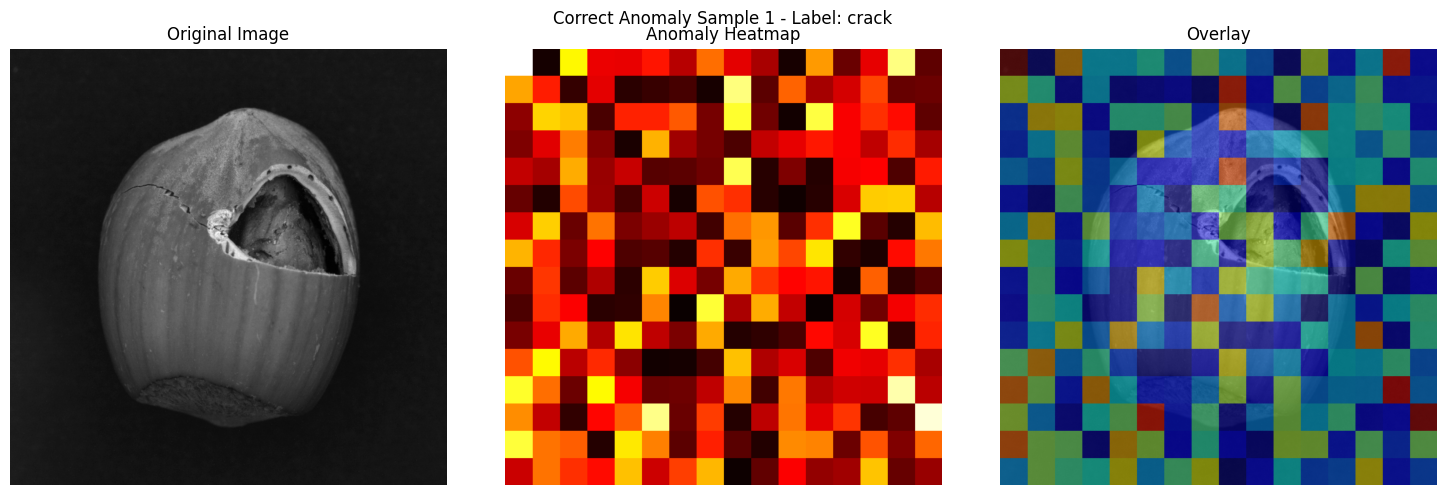

Visualizing Correct Anomaly:  20%|██        | 1/5 [07:10<28:40, 430.23s/it]


Generating heatmap for Correct Anomaly Sample 2...
Segmenting image into superpixels...
Original anomaly score: 3.8867


Perturbing: 100%|██████████| 256/256 [06:50<00:00,  1.60s/it]


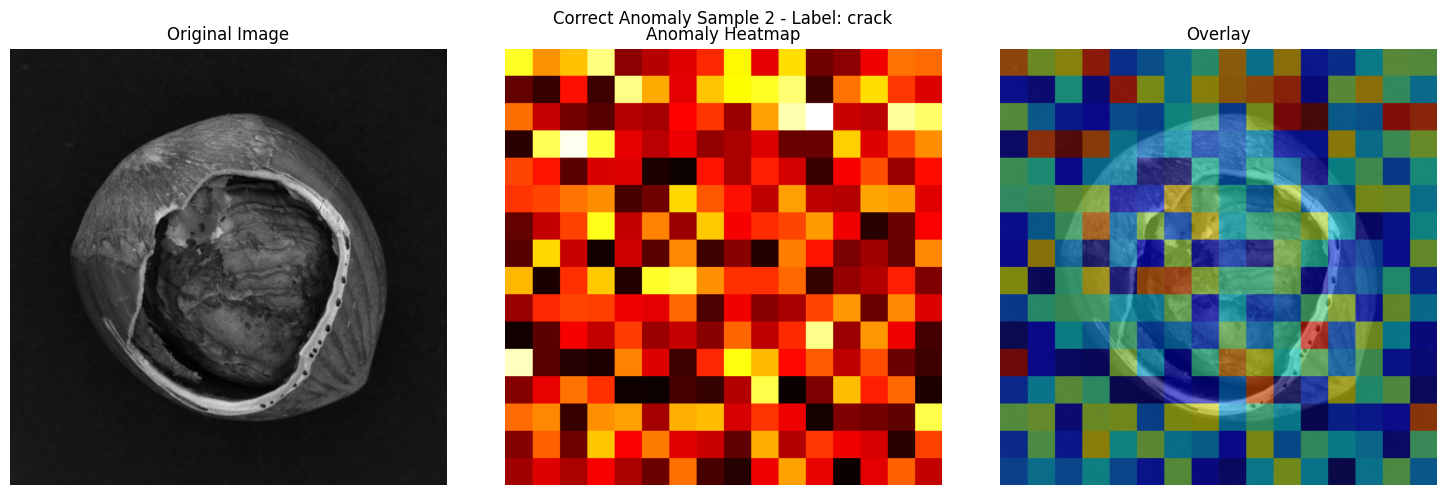

Visualizing Correct Anomaly:  40%|████      | 2/5 [14:03<21:00, 420.14s/it]


Generating heatmap for Correct Anomaly Sample 3...
Segmenting image into superpixels...
Original anomaly score: 3.7735


Perturbing: 100%|██████████| 256/256 [06:39<00:00,  1.56s/it]


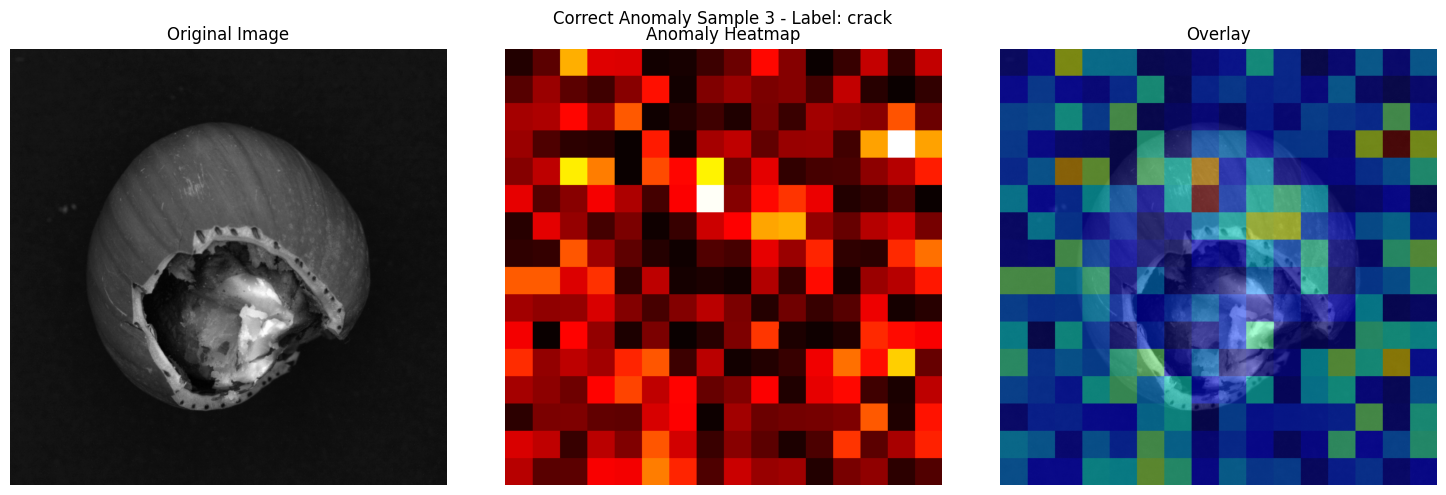

Visualizing Correct Anomaly:  60%|██████    | 3/5 [20:45<13:43, 411.99s/it]


Generating heatmap for Correct Anomaly Sample 4...
Segmenting image into superpixels...
Original anomaly score: 4.1489


Perturbing: 100%|██████████| 256/256 [06:17<00:00,  1.47s/it]


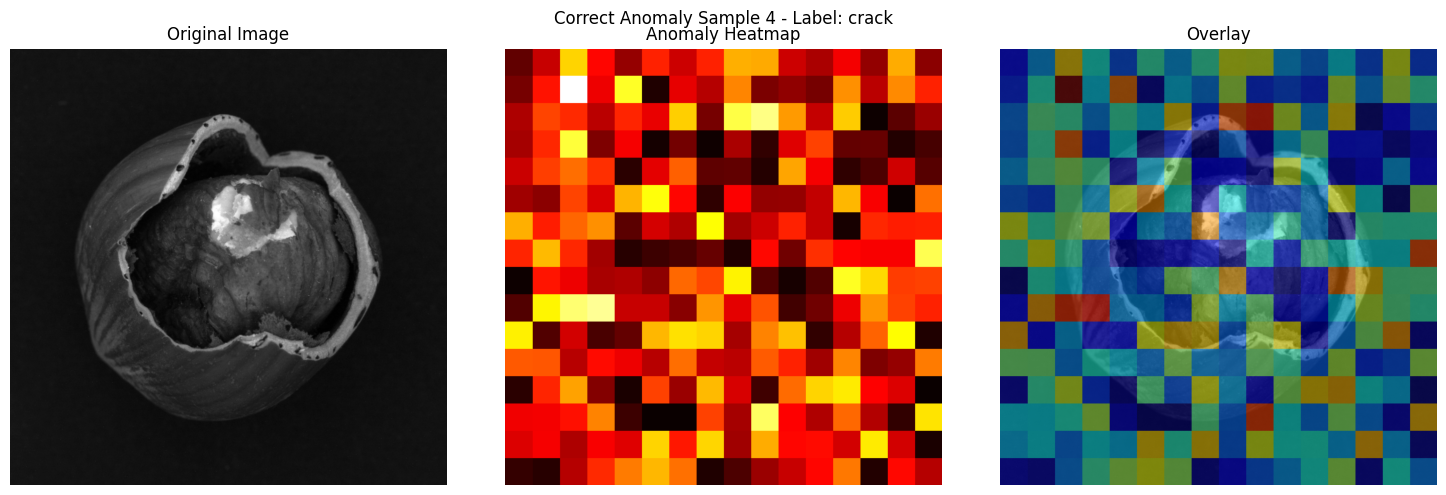

Visualizing Correct Anomaly:  80%|████████  | 4/5 [27:05<06:39, 399.38s/it]


Generating heatmap for Correct Anomaly Sample 5...
Segmenting image into superpixels...
Original anomaly score: 3.8791


Perturbing: 100%|██████████| 256/256 [06:39<00:00,  1.56s/it]


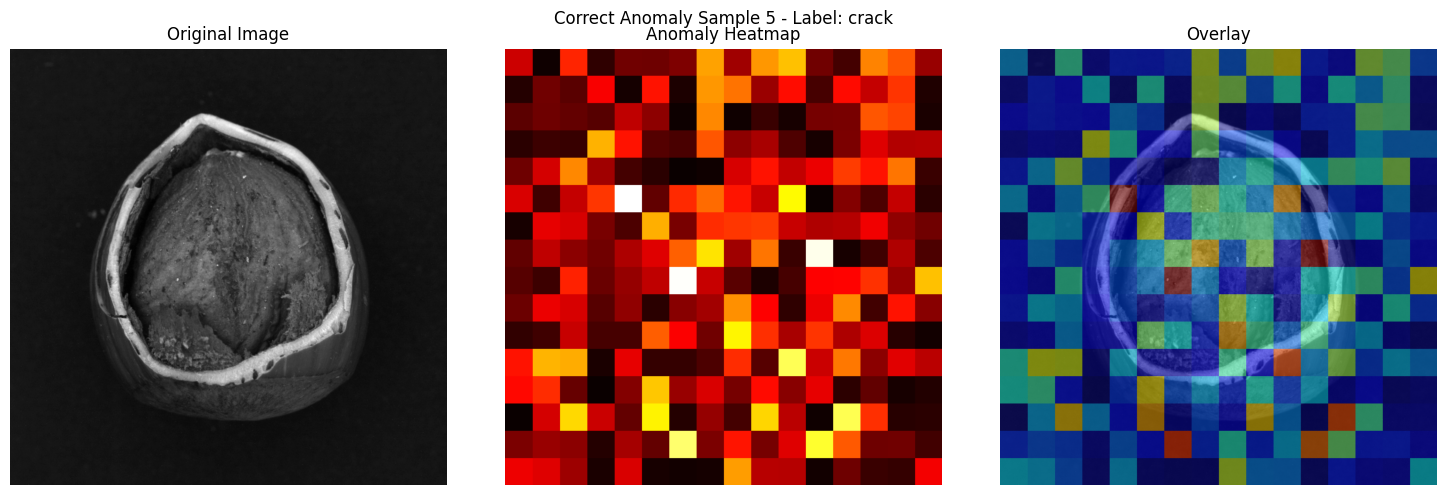

Visualizing Correct Anomaly: 100%|██████████| 5/5 [33:47<00:00, 405.59s/it]



=== INCORRECTLY CLASSIFIED ANOMALIES ===


Visualizing Incorrect Anomaly:   0%|          | 0/5 [00:00<?, ?it/s]


Generating heatmap for Incorrect Anomaly Sample 1...
Segmenting image into superpixels...
Original anomaly score: 3.2660


Perturbing: 100%|██████████| 256/256 [06:30<00:00,  1.53s/it]


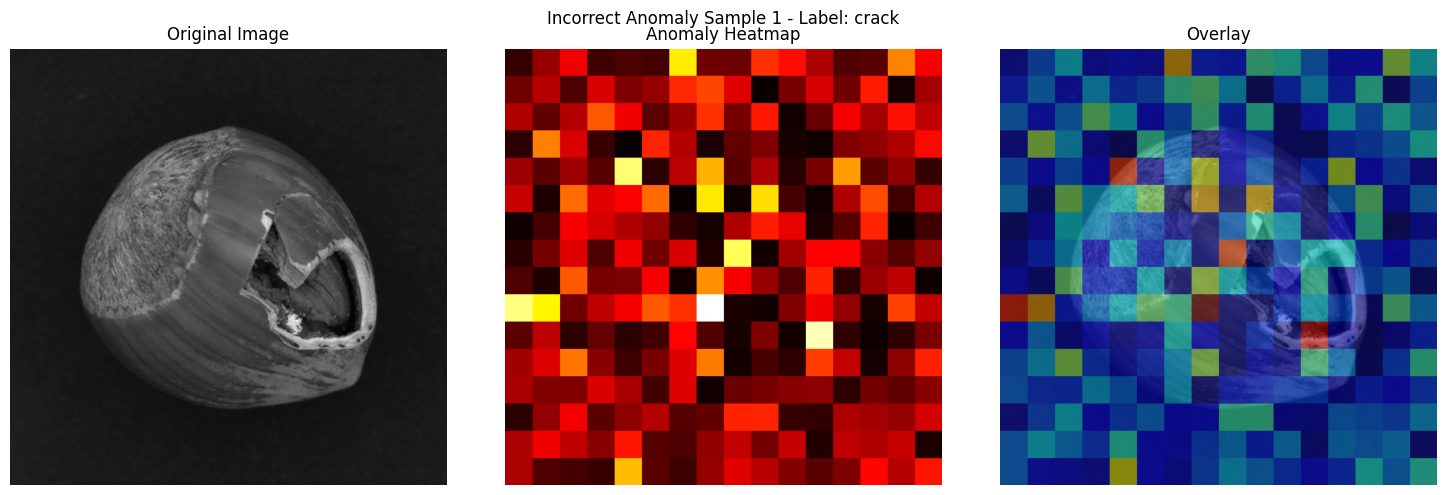

Visualizing Incorrect Anomaly:  20%|██        | 1/5 [06:33<26:15, 393.75s/it]


Generating heatmap for Incorrect Anomaly Sample 2...
Segmenting image into superpixels...
Original anomaly score: 2.9930


Perturbing: 100%|██████████| 256/256 [06:44<00:00,  1.58s/it]


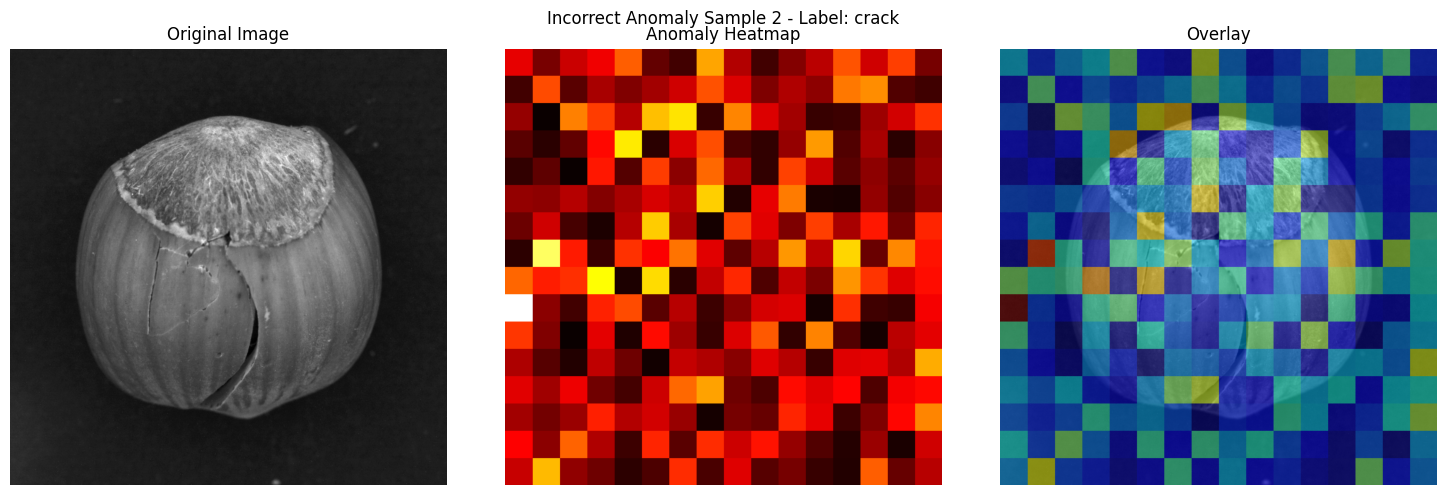

Visualizing Incorrect Anomaly:  40%|████      | 2/5 [13:20<20:04, 401.60s/it]


Generating heatmap for Incorrect Anomaly Sample 3...
Segmenting image into superpixels...
Original anomaly score: 3.0086


Perturbing: 100%|██████████| 256/256 [06:31<00:00,  1.53s/it]


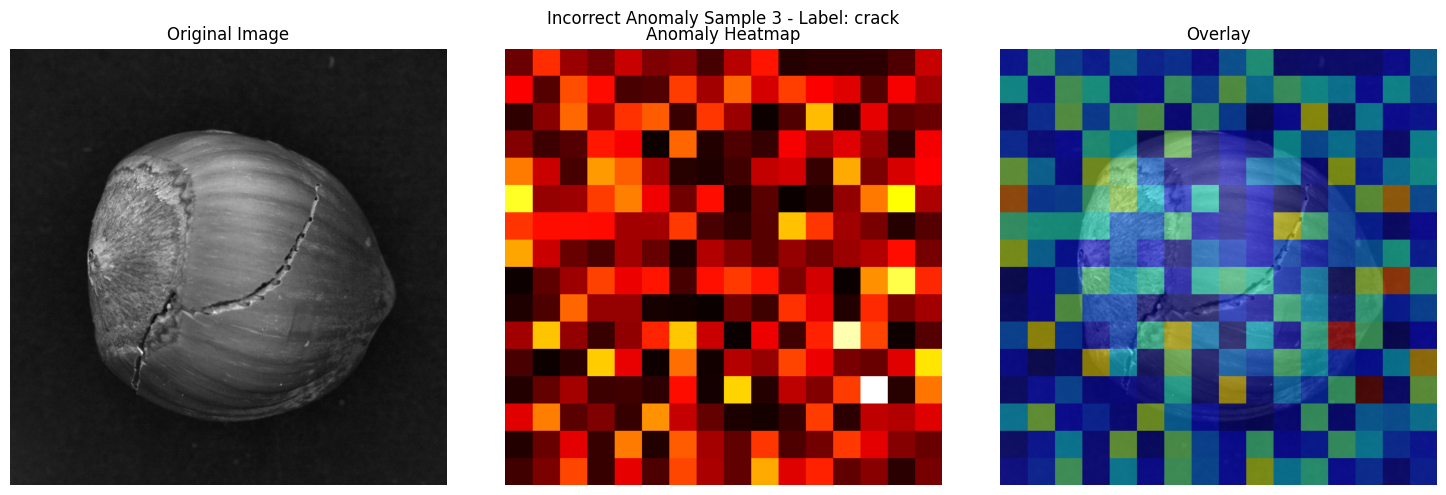

Visualizing Incorrect Anomaly:  60%|██████    | 3/5 [19:54<13:16, 398.12s/it]


Generating heatmap for Incorrect Anomaly Sample 4...
Segmenting image into superpixels...
Original anomaly score: 3.0696


Perturbing: 100%|██████████| 256/256 [07:15<00:00,  1.70s/it]


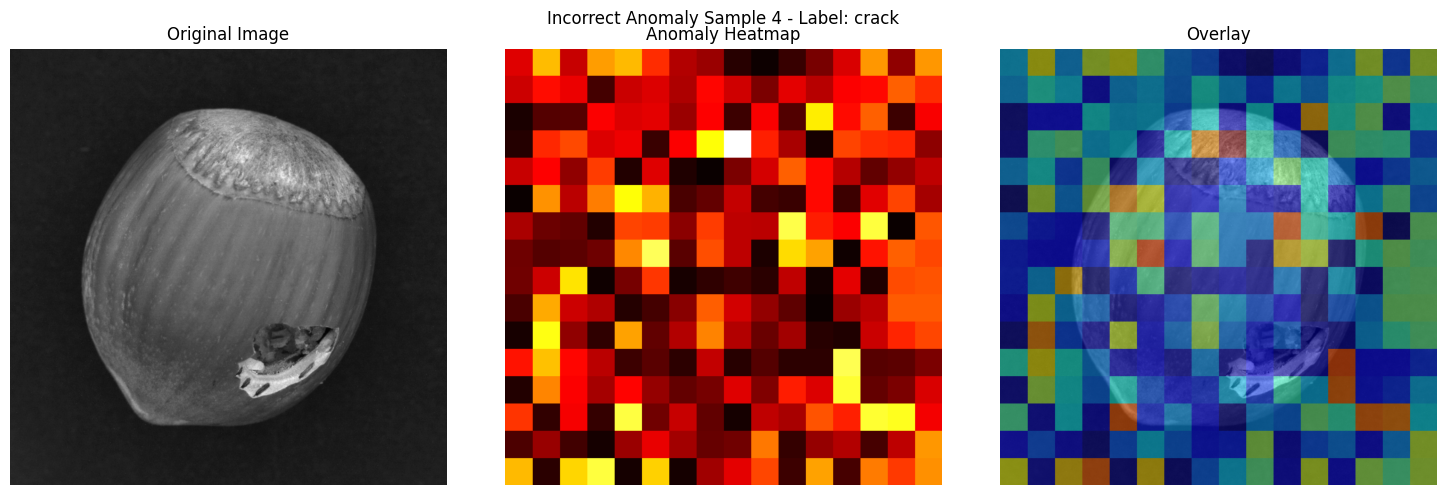

Visualizing Incorrect Anomaly:  80%|████████  | 4/5 [27:13<06:54, 414.00s/it]


Generating heatmap for Incorrect Anomaly Sample 5...
Segmenting image into superpixels...
Original anomaly score: 2.9667


Perturbing: 100%|██████████| 256/256 [08:55<00:00,  2.09s/it]


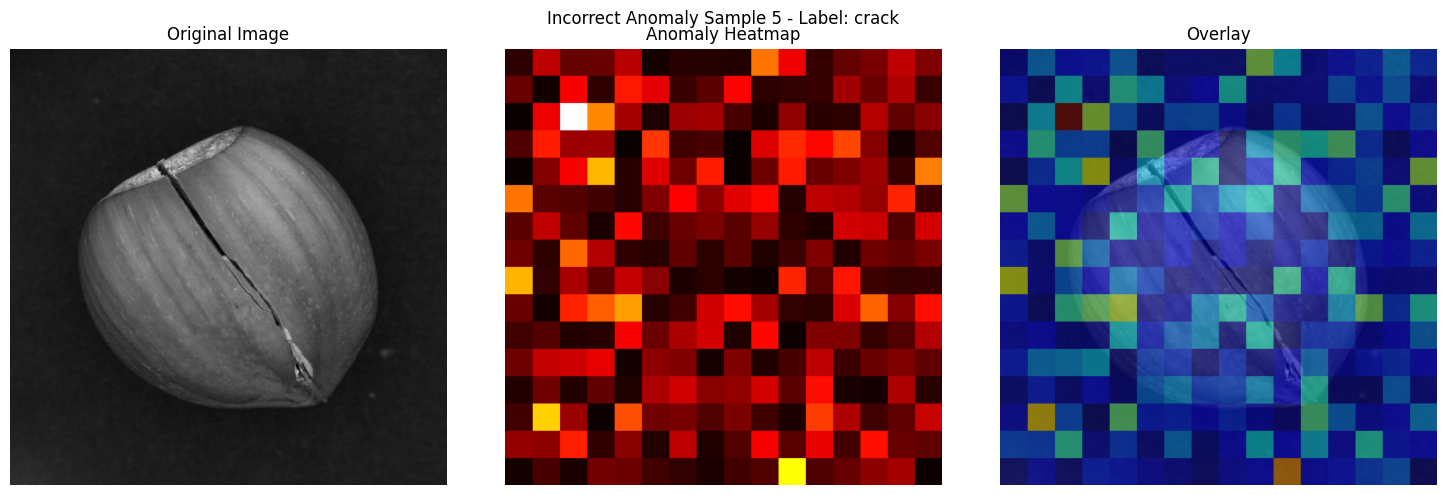

Visualizing Incorrect Anomaly: 100%|██████████| 5/5 [36:11<00:00, 434.37s/it]



=== CORRECTLY CLASSIFIED GOOD IMAGES ===


Visualizing Correct Good:   0%|          | 0/5 [00:00<?, ?it/s]


Generating heatmap for Correct Good Sample 1...
Segmenting image into superpixels...
Original anomaly score: 2.8632


Perturbing: 100%|██████████| 256/256 [07:59<00:00,  1.87s/it]


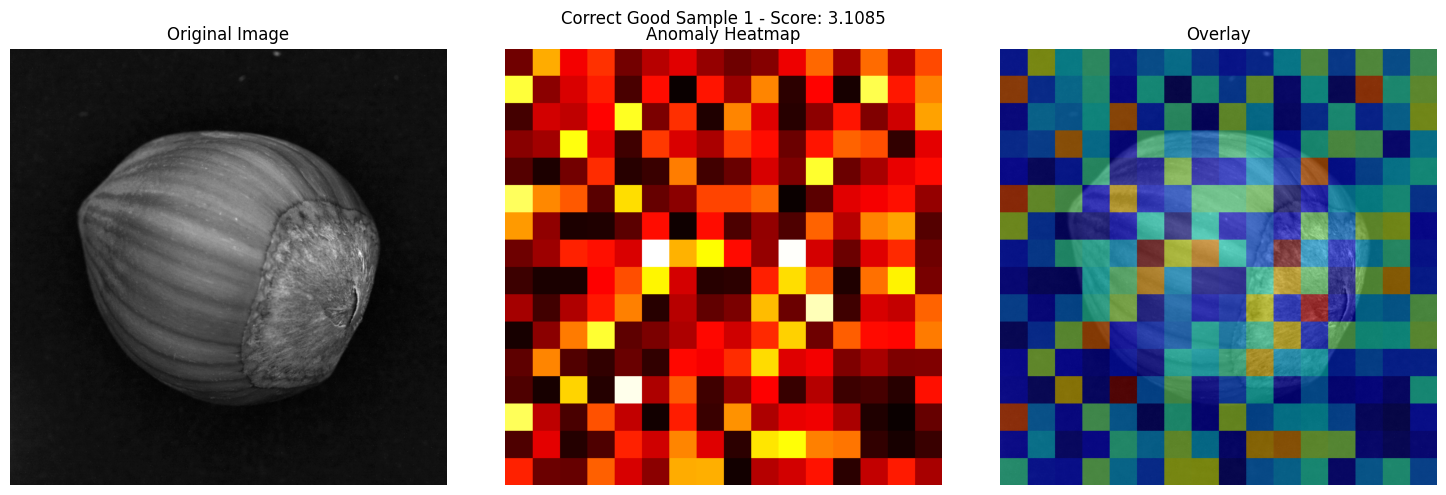

Visualizing Correct Good:  20%|██        | 1/5 [08:03<32:13, 483.48s/it]


Generating heatmap for Correct Good Sample 2...
Segmenting image into superpixels...
Original anomaly score: 2.8795


In [ ]:
from tqdm import tqdm
from skimage.segmentation import slic

def generate_superpixel_anomaly_heatmap(detector, image, n_segments=256, compactness=5):
    print("Segmenting image into superpixels...")
    segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=0, channel_axis=None)
    h, w = image.shape
    heatmap = np.zeros((h, w))

    original_score = detector.detect_anomaly(image)
    print(f"Original anomaly score: {original_score:.4f}")

    for label in tqdm(np.unique(segments), desc="Perturbing"):
        perturbed = image.copy()
        perturbed[segments == label] = 0.0
        perturbed_score = detector.detect_anomaly(perturbed)
        delta = np.abs(perturbed_score - original_score)
        heatmap[segments == label] = delta
    return heatmap


correct_anomalies = []
incorrect_anomalies = []
for i, (img, label) in tqdm(enumerate(zip(test_imgs, test_labels)), total=len(test_imgs), desc="Evaluating anomalies"):
    score = detector.detect_anomaly(img)
    is_anomaly = score >= threshold
    if is_anomaly: correct_anomalies.append((img, label, score))
    else: incorrect_anomalies.append((img, label, score))

correct_goods = []
for img in tqdm(good_imgs, desc="Evaluating good samples"):
    score = detector.detect_anomaly(img)
    if score < threshold: correct_goods.append((img, score))


def visualize_heatmaps(samples, title_prefix, count=5):
    for i, (img, label_or_score, _) in tqdm(list(enumerate(samples[:count])), desc=f"Visualizing {title_prefix}"):
        print(f"\nGenerating heatmap for {title_prefix} Sample {i+1}...")
        heatmap = generate_superpixel_anomaly_heatmap(detector, img)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='hot')
        plt.title("Anomaly Heatmap")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title("Overlay")
        plt.axis('off')

        plt.suptitle(
            f"{title_prefix} Sample {i+1} - Score: {label_or_score:.4f}"
            if isinstance(label_or_score, float)
            else f"{title_prefix} Sample {i+1} - Label: {label_or_score}"
        )
        plt.tight_layout()
        plt.show()

print("\n=== CORRECTLY CLASSIFIED ANOMALIES ===")
visualize_heatmaps(correct_anomalies, title_prefix="Correct Anomaly")

print("\n=== INCORRECTLY CLASSIFIED ANOMALIES ===")
visualize_heatmaps(incorrect_anomalies, title_prefix="Incorrect Anomaly")

print("\n=== CORRECTLY CLASSIFIED GOOD IMAGES ===")
visualize_heatmaps([(img, score, None) for img, score in correct_goods], title_prefix="Correct Good")